# 📊 Unión y Limpieza de datos del Dataset  

---

**Objetivo del Notebook**  
Limpieza de datos, columnas innecesarias y valores nulos/blancos 

**Contexto del análisis**  
- Dataset de muestra proporcionado + csv proporcionado unido en un único excel dataset
- Enfoque en aprendizaje, validación del pipeline y comprensión del proceso

**Valor devuelto**  
- Copia del Dataset de muestra proporcionado completamente limpio y útil 

---




In [1]:
import pandas as pd
import xlsxwriter
import utils
# ===============================
# LEER EL ARCHIVO LIMPIO
# ===============================
dfs = pd.read_excel(r'..\datos\01. Datos originales\DataSET_SF.xlsx', sheet_name=None)

# Ver la primera hoja
oportunidad = list(dfs.values())[0]
cuenta = list(dfs.values())[1]
ecb = list(dfs.values())[2]
solicitud_ban = list(dfs.values())[3]
casos = list(dfs.values())[4]
correos = list(dfs.values())[5]
historial_actividad = list(dfs.values())[6]
historial_etapas = list(dfs.values())[7]


print(historial_etapas.head())

    LK_Oportunidad__c       PL_Etapa__c PL_Subetapa__c  \
0  0061r00000yz6vuAAA  Propuesta centro       Validada   
1  0061r00000yz6vuAAA        Resolución      Publicada   
2  0061r00000yz6vuAAA  Propuesta centro       Validada   
3  0061r00000yz6vuAAA        Resolución      Publicada   
4  0061r00000yz6vuAAA  Propuesta centro       Validada   

                    CreatedDate  CH_Completa_principal__c  \
0  2022-08-02T13:02:10.000+0000                     False   
1  2022-08-02T13:02:10.000+0000                     False   
2  2022-08-02T13:02:36.000+0000                     False   
3  2022-08-03T06:58:58.000+0000                     False   
4  2022-08-03T06:59:30.000+0000                     False   

             Fecha_fin_etapa__c  
0  2022-08-02T13:02:10.000+0000  
1  2022-08-02T13:02:37.000+0000  
2  2022-08-03T06:58:58.000+0000  
3  2022-08-03T06:59:30.000+0000  
4  2022-08-03T07:18:19.000+0000  


In [2]:
from utils import analisis_na_por_columna
analisis_na_por_columna(oportunidad)
analisis_na_por_columna(cuenta)
analisis_na_por_columna(ecb)
analisis_na_por_columna(solicitud_ban)
analisis_na_por_columna(casos)
analisis_na_por_columna(correos)
analisis_na_por_columna(historial_actividad)
analisis_na_por_columna(historial_etapas)

,columna,total_na,porcentaje_na
0,PL_Subetapa__c,104829,21.385294
1,Fecha_fin_etapa__c,57580,11.746418
2,LK_Oportunidad__c,0,0.000000
3,PL_Etapa__c,0,0.000000
4,CreatedDate,0,0.000000
5,CH_Completa_principal__c,0,0.000000


In [3]:
from utils import analisis_na_por_columna, eliminar_columnas_na, crear_target


# ===============================
# LIMPIEZA DE NAS
# ===============================

oportunidad = eliminar_columnas_na(oportunidad)
cuenta = eliminar_columnas_na(cuenta)
ecb = eliminar_columnas_na(ecb)
solicitud_ban = eliminar_columnas_na(solicitud_ban)
casos = eliminar_columnas_na(casos)
correos = eliminar_columnas_na(correos)
historial_actvidad = eliminar_columnas_na(historial_actividad)
historial_etapas = eliminar_columnas_na(historial_etapas)

# ===============================
# CREACION DEL TARJET
# ===============================

target = crear_target(oportunidad, historial_etapas)
target.head()




Hay un total de 15447 matrículas formalizadas. Un 25.79% del total de oportunidades
Hay un total de 1492 desmatriculados. Un 9.66% del total de matriculados


,ID,ACCOUNTID,PL_CURSO_ACADEMICO,PL_TIPO_ACCESO,RECORDTYPEID,RECORDTYPENAME,PL_ESTADO,STAGENAME,PL_SUBETAPA,CH_SIMULTANEIDAD,...,CH_CONDITIONED,CH_SOLICITA_ALOJAMIENTO,NOCONTABILIZABLE,PL_MODALIDAD_EXAMEN_ACCESO_ESC,KITDEVISADO,NU_PASOMAX,NU_PASO_SOLICITUD_ADMISION,CH_ACEPTO_CONDICIONES_MATRICUL,PL_DOMICILIO_DURANTE_CURSO,target
0,0061r00001KLSSJAA5,0011r00002YMDC6AAP,2022/2023,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Validado,Reorientación,Respuesta candidato,false,...,False,False,False,Online,False,1.0,10.0,False,NaN,0
1,0066900001W1pVKAAZ,0016900002mntULAAY,2022/2023,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Pendiente de validar,Cerrada/Perdida,NaN,false,...,False,False,False,Presencial,False,3.0,6.0,False,NaN,0
2,0066900001cHyR5AAK,0016900002vnx7kAAA,2022/2023,Acceso a primero,012w0000000K4QTAA0,Solicitud Matricula Grado,Pendiente de validar,Matrícula OOGG,Formalizada,false,...,False,False,False,Online,False,9.0,9.0,False,5.0,1
3,0066900001MevZwAAJ,0016900002aNZZuAAO,2022/2023,Acceso a primero,012w0000000K4QPAA0,Solicitud Admisión Grado,Validado,Pruebas de admisión,No presentado,false,...,False,False,False,Presencial,False,1.0,10.0,False,NaN,0
4,0066900001VzuaIAAR,0016900002jiFCfAAM,2022/2023,Acceso a primero,012w0000000K4QTAA0,Solicitud Matricula Grado,Pendiente de validar,Matrícula OOGG,Formalizada,false,...,False,False,False,Presencial,False,9.0,9.0,False,1.0,1


# Análisis descriptivo (Seguimiento 1)

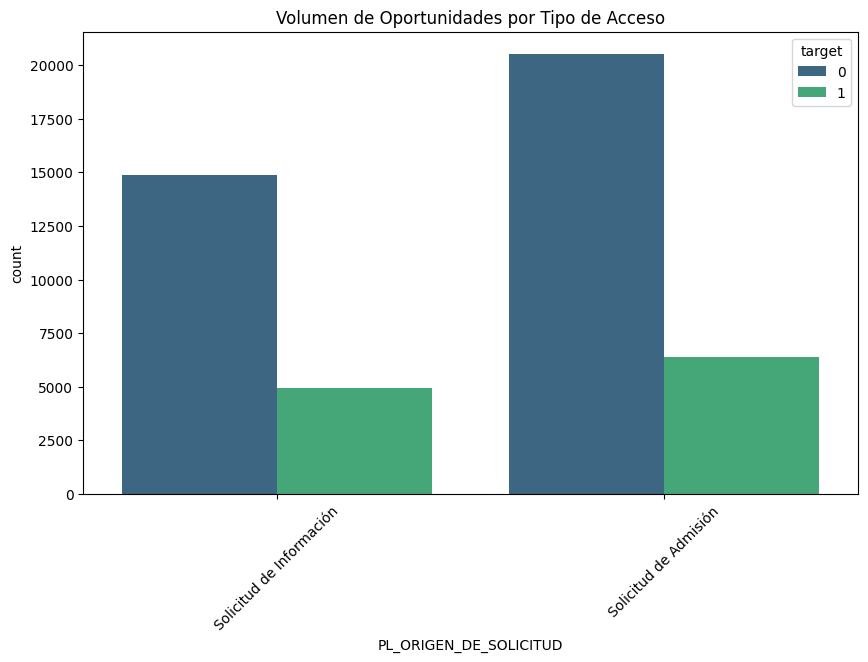

No Matriculado (0)  \
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                         
2022/2023          Solicitud de Admisión                   2884   
                   Solicitud de Información                2148   
2023/2024          Solicitud de Admisión                   2539   
                   Solicitud de Información                1794   
2024/2025          Solicitud de Admisión                   5083   
                   Solicitud de Información                3965   
2025/2026          Solicitud de Admisión                   5157   
                   Solicitud de Información                3622   
2026/2027          Solicitud de Admisión                   4873   
                   Solicitud de Información                3352   

                                             Matriculado (1)  Total  \
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                             
2022/2023          Solicitud de Admisión                1579   4463   
                   Solicitud de Información             1359   3507   
2023/2024          Solicitud de Admisión                 911   3450   
                   Solicitud de Información              604   2398   
2024/2025          Solicitud de Admisión                1824   6907   
                   Solicitud de Información             1410   5375   
2025/2026          Solicitud de Admisión                2057   7214   
                   Solicitud de Información             1567   5189   
2026/2027          Solicitud de Admisión                   0   4873   
                   Solicitud de Información                0   3352   

                                             % Fidelidad  
PL_CURSO_ACADEMICO PL_ORIGEN_DE_SOLICITUD                 
2022/2023          Solicitud de Admisión           35.38  
                   Solicitud de Información        38.75  
2023/2024          Solicitud de Admisión           26.41  
                   Solicitud de Información        25.19  
2024/2025          Solicitud de Admisión           26.41  
                   Solicitud de Información        26.23  
2025/2026          Solicitud de Admisión           28.51  
                   Solicitud de Información        30.20  
2026/2027          Solicitud de Admisión            0.00  
                   Solicitud de Información         0.00

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen numérico con cálculo de porcentaje
resumen_acceso = target.groupby(['PL_CURSO_ACADEMICO', 'PL_ORIGEN_DE_SOLICITUD', 'target'])['ID'].nunique().unstack(fill_value=0)
resumen_acceso.columns = ['No Matriculado (0)', 'Matriculado (1)']

# Calcular Total y % de Matriculados (Tasa de Conversión/Fidelidad)
resumen_acceso['Total'] = resumen_acceso['No Matriculado (0)'] + resumen_acceso['Matriculado (1)']
resumen_acceso['% Fidelidad'] = (resumen_acceso['Matriculado (1)'] / resumen_acceso['Total'] * 100).round(2)


# Gráfico Global de Acceso
plt.figure(figsize=(10, 6))
sns.countplot(data=target.drop_duplicates('ID'), x='PL_ORIGEN_DE_SOLICITUD', hue='target', palette='viridis')
plt.title('Volumen de Oportunidades por Tipo de Acceso')
plt.xticks(rotation=45)
plt.show()
resumen_acceso

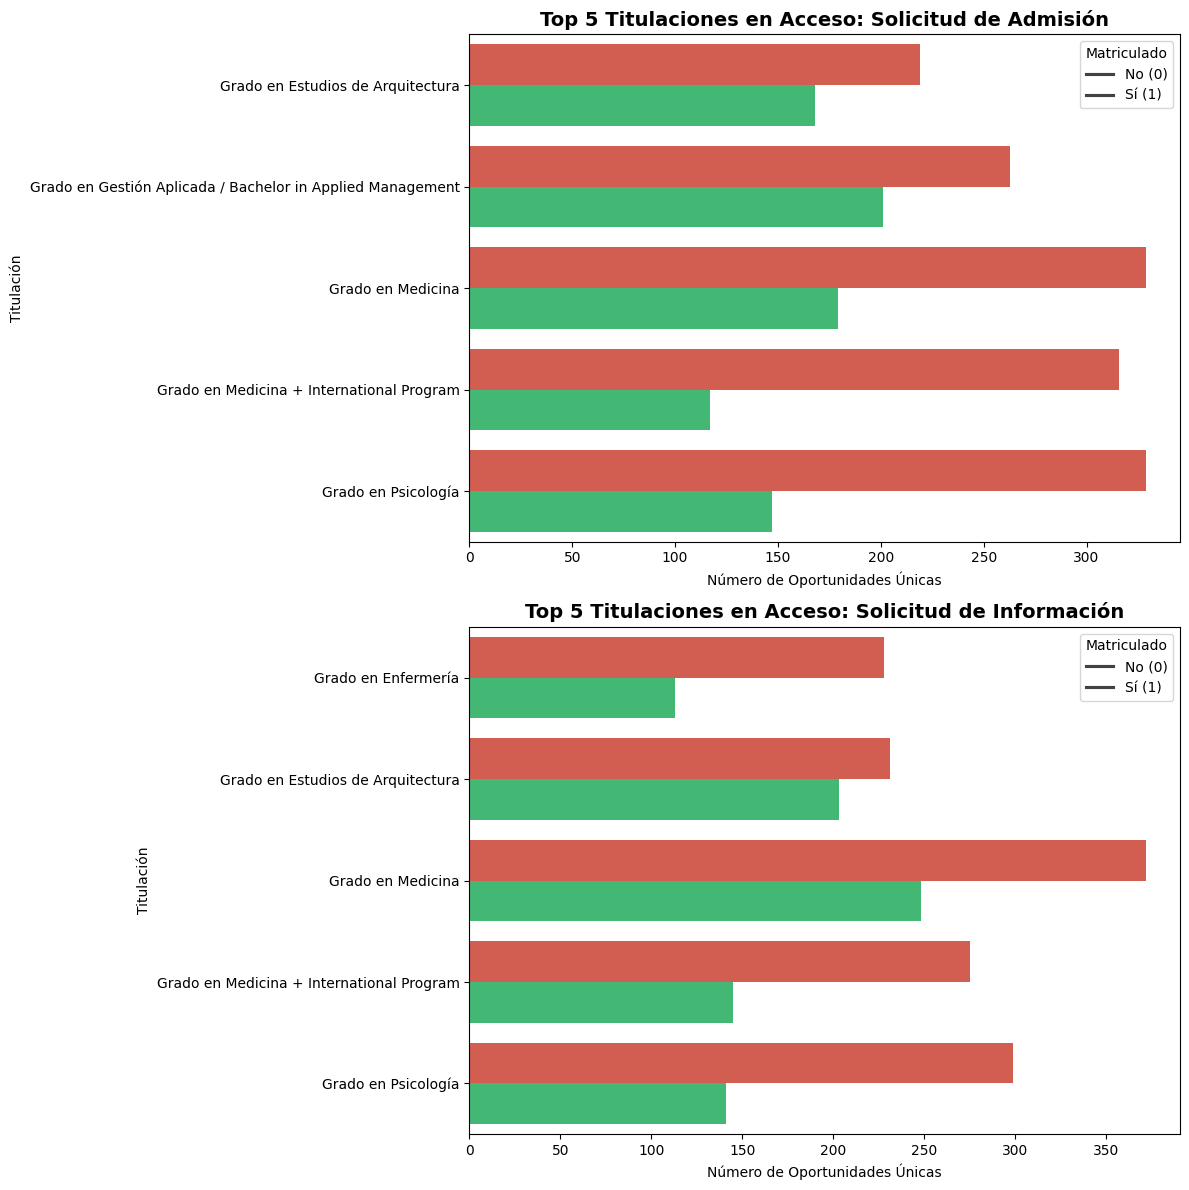

In [11]:
from utils import graficar_top_por_acceso
import matplotlib.pyplot as plt
# Ejecución
graficar_top_por_acceso(target, top_n=5)

In [12]:
columnas_seleccionadas = [
    # Identificadores y Target
    'ACCOUNTID', 'ID','ID18__PC', 'target', 'PL_CURSO_ACADEMICO',
    
    # Rendimiento Académico
    'NU_NOTA_MEDIA_ADMISION', 'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS', 
    'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA', 'TITULACION',
    
    # Compromiso Económico
    'MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 
    'CH_MATRICULA_SUJETA_BECA', 'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL',
    
    # Engagement y Actividad
    'CH_VISITACAMPUS__PC', 'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD', 
    'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA',
    
    # Perfil Sociodemográfico y Fidelidad
    'CH_HIJO_EMPLEADO__PC', 'CH_HIJO_ANTIGUO_ALUMNO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P', 
    'YEARPERSONBIRTHDATE', 'NAMEX', 'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA',
    
    # Origen y Canal
    'LEADSOURCE', 'PL_ORIGEN_DE_SOLICITUD', 'LK_CENTROENSENANZA', 'PL_PLAZO_ADMISION'
]


# Unir la tabla con cuenta y obtener filtrar los datos que nos interesen
df_unido = pd.merge(
    target, 
    cuenta, 
    left_on='ACCOUNTID', 
    right_on='ID18', 
    how='left',
    suffixes=('', '_cuenta')
)		
columnas_finales =  [col for col in columnas_seleccionadas if col in df_unido.columns]
df_unido_filtrado =  df_unido[columnas_finales].copy()


In [16]:
from utils import calcular_tiempos_etapas, limpiar_historial_por_hitos
import numpy as np
import pandas as pd

historial_etapas_tiempo = calcular_tiempos_etapas(historial_etapas)

import pandas as pd
import numpy as np


df_final = limpiar_historial_por_hitos(historial_etapas_tiempo, df_unido_filtrado)

ejemplo_id = '0066900001k7yTgAAI'

columnas_comprobacion = [
    'LK_Oportunidad__c', 'CreatedDate', 'PL_Etapa__c', 'PL_Subetapa__c',
    'fecha_pruebas_calificadas', 'NU_NOTA_MEDIA_ADMISION',
    'fecha_matricula_iniciada', 'PAID_AMOUNT','NU_NOTA_MEDIA_ADMISION', 'CH_PRUEBAS_CALIFICADAS', 
        'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA'
]

print("--- COMPROBACIÓN DE LÓGICA TEMPORAL ---")
df_final[df_final['LK_Oportunidad__c'] == ejemplo_id][columnas_comprobacion].sort_values('CreatedDate')
df_final.head(50)

--- COMPROBACIÓN DE LÓGICA TEMPORAL ---


,LK_Oportunidad__c,PL_Etapa__c,PL_Subetapa__c,CreatedDate,CH_Completa_principal__c,Fecha_fin_etapa__c,tiempo_etapa_dias,tiempo_entre_etapas_dias,fecha_pruebas_calificadas,fecha_matricula_iniciada,...,CH_HIJO_ANTIGUO_ALUMNO__PC,CH_HERMANOS_ESTUDIANDO_UNAV__P,YEARPERSONBIRTHDATE,NAMEX,CH_FAMILIA_NUMEROSA__PC,PL_SITUACION_SOCIO_ECONOMICA,LEADSOURCE,PL_ORIGEN_DE_SOLICITUD,LK_CENTROENSENANZA,PL_PLAZO_ADMISION
0,0061r00000yz6vuAAA,Propuesta centro,Validada,2022-08-02 13:02:10+00:00,False,2022-08-02 13:02:10+00:00,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0061r00000yz6vuAAA,Resolución,Publicada,2022-08-02 13:02:10+00:00,False,2022-08-02 13:02:37+00:00,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0061r00000yz6vuAAA,Propuesta centro,Validada,2022-08-02 13:02:36+00:00,False,2022-08-03 06:58:58+00:00,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0061r00000yz6vuAAA,Resolución,Publicada,2022-08-03 06:58:58+00:00,False,2022-08-03 06:59:30+00:00,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0061r00000yz6vuAAA,Propuesta centro,Validada,2022-08-03 06:59:30+00:00,False,2022-08-03 07:18:19+00:00,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0061r00000yz6vuAAA,Resolución,Publicada,2022-08-03 07:18:19+00:00,False,NaT,0,0,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0061r000010lIlSAAU,Inicio,NaN,2021-11-28 17:57:47+00:00,False,2021-11-28 18:50:00+00:00,0,0,NaT,NaT,...,False,False,2004.0,C. International School of Navarra,False,NaN,Evento,Solicitud de Información,001w000001ac779AAA,Diciembre
7,0061r000010lIlSAAU,Validación,Recibida,2021-11-28 18:50:00+00:00,False,2021-11-30 10:46:42+00:00,1,1,NaT,NaT,...,False,False,2004.0,C. International School of Navarra,False,NaN,Evento,Solicitud de Información,001w000001ac779AAA,Diciembre
8,0061r000010lIlSAAU,Validación,Completa,2021-11-30 10:46:42+00:00,True,2021-11-30 15:00:48+00:00,0,0,NaT,NaT,...,False,False,2004.0,C. International School of Navarra,False,NaN,Evento,Solicitud de Información,001w000001ac779AAA,Diciembre
9,0061r000010lIlSAAU,Pruebas de admisión,Convocado,2021-11-30 15:00:48+00:00,False,2021-12-16 10:58:40+00:00,15,15,NaT,NaT,...,False,False,2004.0,C. International School of Navarra,False,NaN,Evento,Solicitud de Información,001w000001ac779AAA,Diciembre


In [17]:
import pandas as pd
import numpy as np
from utils import integrar_actividades_progresivo_por_curso
# Ejecución
df_final_v3 = integrar_actividades_progresivo_por_curso(df_final, historial_actividad)
# ==========================================
# EJECUCIÓN
# ==========================================
# Print de comprobación para ver la evolución de un contacto
ejemplo_acc = df_final_v3[df_final_v3['num_asistencias_acum'] > 0]['ID18__PC'].iloc[1]
cols_print = ['ID','ID18__PC','ACCOUNTID', 'CreatedDate', 'PL_Etapa__c', 'num_asistencias_acum', 'num_solicitudes_acum']

print("\n--- COMPROBACIÓN DE EVOLUCIÓN DE ACTIVIDADES ---")
df_final_v3[df_final_v3['ID18__PC'] == ejemplo_acc][cols_print].sort_values('CreatedDate')
#historial_actividad.loc[historial_actividad['ContactId']=='003690000312P6pAAE',]

Procesando 540839 filas con lógica de curso y progresión temporal...
Cruzando datos por ID18__PC y Curso Académico...
Aplicando filtro temporal progresivo...
Agrupando resultados...
Consolidando en el DataFrame maestro...
✅ Proceso completado.

--- COMPROBACIÓN DE EVOLUCIÓN DE ACTIVIDADES ---


,ID,ID18__PC,ACCOUNTID,CreatedDate,PL_Etapa__c,num_asistencias_acum,num_solicitudes_acum
2415,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-02-25 18:10:48+00:00,Información,0,0
2416,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-10-03 10:20:32+00:00,Inicio,0,0
2417,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-10-21 19:51:42+00:00,Cerrada/Perdida,0,0
2418,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-10-21 19:52:20+00:00,Inicio,0,0
2419,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-10-24 18:24:59+00:00,Validación,1,1
2420,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-10-25 09:15:00+00:00,Validación,1,1
2421,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-12-16 08:37:56+00:00,Pruebas de admisión,1,1
2422,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-12-16 09:05:00+00:00,Pruebas de admisión,1,1
2423,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2021-12-16 09:45:00+00:00,Estudio Centro,1,1
2424,0066900001NaGn4AAF,003690000312P6pAAE,0016900002dZM7DAAW,2022-01-07 10:04:53+00:00,Estudio Centro,1,1


In [19]:
# ===============================
# 3. GUARDAR EXCEL LIMPIO
# ===============================
df_integrado.to_csv(r"..\datos\02. Datos tratamiento preliminar\01_datos_tratamiento_preliminar - V2.csv",sep=";")

print("Archivo limpio guardado como '01_datos_tratamiento_preliminar - V2.csv'")

NameError: name 'df_integrado' is not defined

# 📊 Creación del Dataset Maestro

---

**Objetivo del Notebook**  
Creacion del dataset maestro una vez obtenido el dataset limpio

**Contexto del análisis**  
- Dataset limpio en etapas anteriores

**Valor devuelto**  
- Copia del Dataset de muestra proporcionado completamente funcional

---




TAREA 1: Comprobar que el conjunto de datos contiene todas las variables importantes de la pestaña de cuenta: Variables relacionadas con el origen del alumno: nacional o internacional, colegio de procedencia, si el colegio es afín o no a la UNAV, si es hijo de empleado o de profesor asociado (por los descuentos en matrícula), si es familia numerosa y de qué tipo.

In [20]:
# ===============================
# VARIABLES CLAVE ESPERADAS (CUENTA)
# ===============================

variables_cuenta_clave = {
    "Origen del alumno": [
        "PL_NACIONALIDAD__C",          # cambiar por colegio
        "PL_TIPO_ALUMNO__C"            # Nacional / Internacional (alternativa frecuente)
    ],
    
    "Colegio de procedencia": [
        "LK_CENTROENSENANZA",
        "CH_CENTRO_AFIN_UNAV__C"       # Colegio afín a UNAV, añadir nota media 1º bachillerato, hijo empleado, hijo medico, hijo hermanos en la unav, etc
    ],
    
    "Vínculo con UNAV (descuentos)": [
        "CH_HIJO_EMPLEADO__PC",
        "CH_HIJO_PROFESOR_ASOCIADO__C" # si existe
    ],
    
    "Familia numerosa": [
        "CH_FAMILIA_NUMEROSA__PC",
        "PL_TIPO_FAMILIA_NUMEROSA__C"  # general / especial, añadir nº miembros de la familia, 
    ]
}



In [21]:
# ===============================
# COMPROBACIÓN DE EXISTENCIA EN CUENTA: verificamos qué está y qué falta realmente en el dataframe cuenta.
# ===============================

columnas_cuenta = set(cuenta.columns)

estado_variables = []

for bloque, vars_bloque in variables_cuenta_clave.items():
    for var in vars_bloque:
        estado_variables.append({
            "Bloque": bloque,
            "Variable": var,
            "Existe_en_cuenta": var in columnas_cuenta
        })

df_estado_variables = pd.DataFrame(estado_variables)
df_estado_variables


,Bloque,Variable,Existe_en_cuenta
0,Origen del alumno,PL_NACIONALIDAD__C,False
1,Origen del alumno,PL_TIPO_ALUMNO__C,False
2,Colegio de procedencia,LK_CENTROENSENANZA,False
3,Colegio de procedencia,CH_CENTRO_AFIN_UNAV__C,False
4,Vínculo con UNAV (descuentos),CH_HIJO_EMPLEADO__PC,True
5,Vínculo con UNAV (descuentos),CH_HIJO_PROFESOR_ASOCIADO__C,False
6,Familia numerosa,CH_FAMILIA_NUMEROSA__PC,True
7,Familia numerosa,PL_TIPO_FAMILIA_NUMEROSA__C,False


In [22]:
# ===============================
# COMPROBAR PRESENCIA EN DATASET FINAL: comprobamos si esas variables han sobrevivido al cruce y están en el dataset final.
# ===============================

columnas_final = set(df_integrado.columns)

df_estado_variables["Existe_en_df_integrado"] = (
    df_estado_variables["Variable"].isin(columnas_final)
)

df_estado_variables


NameError: name 'df_integrado' is not defined

In [23]:
# ===============================
# CALIDAD DE VARIABLES EXISTENTES: Para las que sí existen en df_integrado, comprobamos si tienen datos útiles.
# ===============================

vars_validas = df_estado_variables.loc[
    df_estado_variables["Existe_en_df_integrado"],
    "Variable"
].tolist()

calidad = (
    df_integrado[vars_validas]
    .isna()
    .mean()
    .reset_index()
    .rename(columns={"index": "Variable", 0: "% NA"})
)

calidad["% NA"] = (calidad["% NA"] * 100).round(2)
calidad.sort_values("% NA", ascending=False)


KeyError: 'Existe_en_df_integrado'

In [24]:
# ===============================
# CONCLUSIÓN AUTOMÁTICA
# ===============================

conclusion = df_estado_variables.copy()
conclusion["Estado"] = np.select(
    [
        ~conclusion["Existe_en_cuenta"],
        conclusion["Existe_en_cuenta"] & ~conclusion["Existe_en_df_integrado"],
        conclusion["Existe_en_df_integrado"]
    ],
    [
        "❌ No existe en origen",
        "⚠️ Existe en cuenta pero no llegó al dataset final",
        "✅ Disponible en dataset final"
    ]
)

conclusion

#REVISAR LA NACIONALIDAD POR SI SE LLAMA DISTINTO (EN EL EXCEL)


KeyError: 'Existe_en_df_integrado'

TAREA 2: Comprobar que el target se ha creado correctamente, que no hay valores vacíos. En caso de tener valores vacíos, comprobar de donde vienen y porqué ocurren. Comprobar que las variables importantes de oportunidad aparecen en el conjunto de datos: tipo de solicitud (Información o admisión), plazo de admisión(con un tratamiento de si es Diciembre, Marzo o Rolling [que es cuando solicitas la prueba y la haces a los días, suele aparecer en blanco] y tratar de construir bien esta variable), nu_preferencia (con el orden de preferencia), si ha pagado, el pago mínimo, notas de admisión, etc. Asegurar que no aparece información de futuro en etapas anteriores. 


In [ ]:
# ===============================
# VALIDACIÓN BÁSICA DEL TARGET
# ===============================

print("Valores únicos del target:")
print(df_integrado['target'].value_counts(dropna=False))

print("\nNúmero de target nulos:")
print(df_integrado['target'].isna().sum())

# ===============================
# ANÁLISIS DE TARGET NULOS
# ===============================

target_nulos = df_integrado[df_integrado['target'].isna()]

print(f"Registros con target nulo: {len(target_nulos)}")

target_nulos[['ID', 'STAGENAME', 'PL_SUBETAPA']].head()

# ===============================
# COMPROBAR ORIGEN DEL PROBLEMA
# ===============================

ids_target_nulo = set(target_nulos['ID'])
ids_historial = set(historial_etapas['LK_Oportunidad__c'])

print("IDs con target nulo SIN historial:",
      len(ids_target_nulo - ids_historial))


Valores únicos del target:
target
0.0    327854
1.0    208744
Name: count, dtype: int64

Número de target nulos:
0
Registros con target nulo: 0
IDs con target nulo SIN historial: 0


In [ ]:
# ===============================
# VARIABLES CLAVE DE OPORTUNIDAD
# ===============================

variables_op_clave = {
    "Tipo de solicitud": [
        "PL_ORIGEN_DE_SOLICITUD",  # Información / Admisión
        "CH_ORIGEN_ADMISION"
    ],
    
    "Plazo de admisión": [
        "PL_PLAZO_ADMISION"
    ],
    
    "Preferencia": [
        "NU_PREFERENCIA"
    ],
    
    "Pago": [
        "CH_PAGADO__C",
        "MINIMUMPAYMENTPAYED",
        "IMPORTE_MINIMO_PERSONALIZADO"
    ],
    
    "Notas admisión": [
        "NU_NOTA_MEDIA_ADMISION",
        "NU_RESULTADO_ADMISION_PUNTOS"
    ]
}

# ===============================
# EXISTENCIA DE VARIABLES
# ===============================

estado_op = []

for bloque, vars_bloque in variables_op_clave.items():
    for var in vars_bloque:
        estado_op.append({
            "Bloque": bloque,
            "Variable": var,
            "Existe_en_df_integrado": var in df_integrado.columns
        })

df_estado_op = pd.DataFrame(estado_op)
df_estado_op


In [ ]:
df_integrado['PL_PLAZO_ADMISION'].value_counts(dropna=False)

# ===============================
# CONSTRUCCIÓN PLAZO LIMPIO
# ===============================

def normalizar_plazo(x):
    if pd.isna(x):
        return "Rolling"
    x = x.strip().lower()
    if "dic" in x:
        return "Diciembre"
    if "mar" in x:
        return "Marzo"
    return "Otros"

df_integrado['PLAZO_ADMISION_LIMPIO'] = (
    df_integrado['PL_PLAZO_ADMISION']
    .apply(normalizar_plazo)
)

df_integrado['PLAZO_ADMISION_LIMPIO'].value_counts()


PLAZO_ADMISION_LIMPIO
Otros        256829
Diciembre    184478
Marzo         78561
Rolling       16730
Name: count, dtype: int64

In [ ]:
# ===============================
# COMPROBACIÓN VARIABLES ECONÓMICAS Y DE PAGO
# ===============================

# Variables económicas que queremos analizar
vars_pago_esperadas = [
    'CH_PAGADO__C',
    'MINIMUMPAYMENTPAYED',
    'IMPORTE_MINIMO_PERSONALIZADO',
    'PAID_AMOUNT',
    'PAID_PERCENT'
]

# Filtrar solo las columnas que existen en df_integrado
vars_pago_existentes = [v for v in vars_pago_esperadas if v in df_integrado.columns]

# Mostrar cuáles existen y cuáles no
print("Variables encontradas en df_integrado:", vars_pago_existentes)
vars_faltantes = [v for v in vars_pago_esperadas if v not in df_integrado.columns]
if vars_faltantes:
    print("⚠️ Variables no encontradas en df_integrado (no se incluyen en análisis):", vars_faltantes)

# Descripción estadística solo de las variables existentes
if vars_pago_existentes:
    print("\n--- Descripción de las variables de pago existentes ---")
    display(df_integrado[vars_pago_existentes].describe())
else:
    print("❌ Ninguna de las variables de pago esperadas está disponible en df_integrado.")

# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA
# ===============================

# Ejemplo: comprobar pagos antes de la etapa Matrícula
if 'PAID_AMOUNT' in df_integrado.columns:
    casos_incoherentes = df_integrado[
        (df_integrado['PL_Etapa__c'] != 'Matrícula') &
        (df_integrado['PAID_AMOUNT'] > 0)
    ]
    print(f"\n⚠️ Casos con pagos antes de Matrícula: {len(casos_incoherentes)}")
    display(casos_incoherentes[['ID','PL_Etapa__c','PAID_AMOUNT','target']])


Variables encontradas en df_integrado: ['MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT']
⚠️ Variables no encontradas en df_integrado (no se incluyen en análisis): ['CH_PAGADO__C', 'IMPORTE_MINIMO_PERSONALIZADO']

--- Descripción de las variables de pago existentes ---


,MINIMUMPAYMENTPAYED,PAID_AMOUNT,PAID_PERCENT
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN



⚠️ Casos con pagos antes de Matrícula: 0


,ID,PL_Etapa__c,PAID_AMOUNT,target


In [ ]:


df_integrado['NU_PREFERENCIA'].describe()
#df_integrado[['CH_PAGADO__C', 'MINIMUMPAYMENTPAYED', 'IMPORTE_MINIMO_PERSONALIZADO']].describe()


# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA
# ===============================

casos_incoherentes = df_integrado[
    (df_integrado['PL_Etapa__c'] != 'Matrícula') &
    (df_integrado['PAID_AMOUNT'] > 0)
]

print("Casos con pago antes de etapa de matrícula:",
      len(casos_incoherentes))



Casos con pago antes de etapa de matrícula: 0


TAREA 3: De la pestaña ECB nos interesan tres variables por oportunidad: La renta familiar, el coste ordinario (el coste sin aplicar ningún tipo de descuento) y el Importe matrícula a pagar (que es el valor final que es el importe que paga el alumno con todos los descuentos aplicados), el % del total que acaba pagando el alumno (importe matrícula/coste ordinario * 100). Importante que no aparezca esta variable informada antes de que se realice el estudio de la beca, se puede comprobar con la fecha de la etapa en la que se encuentra la oportunidad y la fecha de solicitud de la beca, en el caso que no haya un cruce más sencillo)

In [ ]:
df_integrado = df_final_filtrado.merge(
    ecb[
        [
            'LK_oportunidad__c',
            'FO_rentaMEC_for__c',
            'FO_rentaFam_ges__c',
            'CU_precioOrdinario_def__c',
            'CU_precioIncentivado_def__c',
            'CU_precioFamNum_def__c',
            'PO_descFamNum_def__c',
            'CU_precioAplicado_def__c'
        ]
    ],
    left_on='ID',
    right_on='LK_oportunidad__c',
    how='left'
)

# ===============================
# VARIABLES ECONÓMICAS ECB FINALES
# ===============================

vars_ecb = [
    'FO_rentaFam_ges__c',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

print("Variables ECB disponibles:")
print([v for v in vars_ecb if v in df_integrado.columns])

df_integrado[vars_ecb].describe()


Variables ECB disponibles:
['FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c']


,FO_rentaFam_ges__c,CU_precioOrdinario_def__c,CU_precioAplicado_def__c
count,5.962800e+04,5.157000e+04,4.365400e+04
mean,9.188794e+04,7.696008e+05,6.517655e+05
std,4.731495e+05,4.911901e+06,5.544944e+06
min,0.000000e+00,3.918600e+03,2.187600e+03
25%,2.679768e+04,1.440000e+04,1.116522e+04
50%,5.937878e+04,1.622544e+04,1.419540e+04
75%,9.569859e+04,1.860000e+04,1.750050e+04
max,3.375774e+07,3.529012e+07,1.139021e+08


In [ ]:
# ===============================
# % PAGADO SOBRE COSTE ORDINARIO
# ===============================

df_integrado['PORCENTAJE_PAGADO_FINAL'] = (
    df_integrado['CU_precioAplicado_def__c'] /
    df_integrado['CU_precioOrdinario_def__c']
) * 100

# Control de valores infinitos o incoherentes
df_integrado.loc[
    df_integrado['CU_precioOrdinario_def__c'] <= 0,
    'PORCENTAJE_PAGADO_FINAL'
] = np.nan

df_integrado['PORCENTAJE_PAGADO_FINAL'].describe()


count     41236.000000
mean        111.096947
std        1646.022424
min           0.035000
25%          74.999045
50%          91.998994
75%         100.000000
max      100857.687421
Name: PORCENTAJE_PAGADO_FINAL, dtype: float64

In [ ]:
df_integrado['PL_Etapa__c'].value_counts()

# ===============================
# DETECCIÓN DE INFORMACIÓN FUTURA (ECB)
# ===============================

etapas_previas_beca = [
    'Solicitud',
    'Pruebas',
    'Admisión académica'
]

casos_info_futura = df_integrado[
    (df_integrado['PL_Etapa__c'].isin(etapas_previas_beca)) &
    (df_integrado['CU_precioAplicado_def__c'].notna())
]

print("Casos con importe final antes del estudio de beca:",
      len(casos_info_futura))

casos_info_futura[
    ['ID', 'PL_Etapa__c', 'CU_precioAplicado_def__c', 'FO_rentaFam_ges__c']
].head()


Casos con importe final antes del estudio de beca: 0


,ID,PL_Etapa__c,CU_precioAplicado_def__c,FO_rentaFam_ges__c


In [ ]:
df_integrado.loc[
    df_integrado['PL_Etapa__c'].isin(etapas_previas_beca),
    ['CU_precioAplicado_def__c', 'PORCENTAJE_PAGADO_FINAL']
] = np.nan


TAREA 4: De la pestaña de etapas, obtener el tiempo que lleva en cada etapa. En caso de ser la etapa actual, que se calcule como el tiempo entre el inicio de la etapa y la fecha de hoy en días.

In [ ]:
# ===============================
# TIEMPO EN CADA ETAPA (SOLUCIÓN FINAL ABSOLUTA)
# ===============================

import pandas as pd
import numpy as np

df_etapas = historial_etapas.copy()

# Asegurar datetime (pandas)
df_etapas['CreatedDate'] = pd.to_datetime(
    df_etapas['CreatedDate'],
    errors='coerce'
)

# Orden correcto
df_etapas = df_etapas.sort_values(
    by=['LK_Oportunidad__c', 'CreatedDate']
)

# Fecha siguiente etapa
df_etapas['fecha_siguiente_etapa'] = (
    df_etapas
    .groupby('LK_Oportunidad__c')['CreatedDate']
    .shift(-1)
)

df_etapas['fecha_siguiente_etapa'] = pd.to_datetime(
    df_etapas['fecha_siguiente_etapa'],
    errors='coerce'
)

# Fecha de hoy
fecha_hoy = np.datetime64(pd.Timestamp.today().normalize())

# Fecha fin: si no hay siguiente etapa → hoy
fecha_fin = np.where(
    df_etapas['fecha_siguiente_etapa'].isna(),
    fecha_hoy,
    df_etapas['fecha_siguiente_etapa'].to_numpy(dtype='datetime64[ns]')
)

# Fecha inicio como numpy datetime
fecha_inicio = df_etapas['CreatedDate'].to_numpy(dtype='datetime64[ns]')

# 🔥 CÁLCULO DEFINITIVO EN DÍAS
df_etapas['dias_en_etapa'] = (
    (fecha_fin - fecha_inicio) / np.timedelta64(1, 'D')
).astype(int)

# Limpieza defensiva
df_etapas.loc[df_etapas['dias_en_etapa'] < 0, 'dias_en_etapa'] = 0

# Resultado
df_etapas[
    [
        'LK_Oportunidad__c',
        'PL_Etapa__c',
        'CreatedDate',
        'fecha_siguiente_etapa',
        'dias_en_etapa'
    ]
].head()


,LK_Oportunidad__c,PL_Etapa__c,CreatedDate,fecha_siguiente_etapa,dias_en_etapa
60684,0061r00000yz6vuAAA,Propuesta centro,2022-08-02 13:02:10+00:00,2022-08-02 13:02:10+00:00,0
60685,0061r00000yz6vuAAA,Resolución,2022-08-02 13:02:10+00:00,2022-08-02 13:02:36+00:00,0
60686,0061r00000yz6vuAAA,Propuesta centro,2022-08-02 13:02:36+00:00,2022-08-03 06:58:58+00:00,0
60765,0061r00000yz6vuAAA,Resolución,2022-08-03 06:58:58+00:00,2022-08-03 06:59:30+00:00,0
60766,0061r00000yz6vuAAA,Propuesta centro,2022-08-03 06:59:30+00:00,2022-08-03 07:18:19+00:00,0


TAREA 5: De la pestaña de historial de actividades obtener el número de actividades que lleva asistidas hasta esa etapa, comprobar que se calcula bien. Si da tiempo, añadir las actividades de la pestaña casos que son "Asistencia familias" para que se cuente como actividad. Importante comprobar que no se cuentan actividades futuras.

In [ ]:
# ===============================
# LIMPIEZA ACTIVIDADES
# ===============================

df_act = df_actividades.copy()

# Fecha actividad
df_act['fecha_actividad'] = pd.to_datetime(
    df_act['ActivityDate'],
    errors='coerce'
)

# Nos quedamos solo con actividades asistidas / completadas
df_act = df_act[
    df_act['Status'].isin(['Asistida', 'Completada', 'Completed'])
]

df_act = df_act[
    ['LK_Oportunidad__c', 'fecha_actividad']
].dropna()

#Restore hasta aqui

NameError: name 'df_actividades' is not defined

TAREA 6: Comprobar varios ejemplos y asegurar que no hay variables informadas con información del futuro.

In [27]:
# ============================================================
# TAREA 6 · COMPROBACIÓN DE INFORMACIÓN DEL FUTURO (LEAKAGE)
# ============================================================

import pandas as pd
import numpy as np

print("🔍 INICIO COMPROBACIÓN DE INFORMACIÓN DEL FUTURO\n")

# ===============================
# 1. DEFINICIÓN DE REGLAS TEMPORALES
# ===============================

reglas_futuro = {
    "Pago y matrícula": {
        "etapas_no_permitidas": [
            'Solicitud',
            'Pruebas',
            'Admisión académica'
        ],
        "variables": [
            'PAID_AMOUNT',
            'MINIMUMPAYMENTPAYED',
            'CH_PAGADO__C',
            'CU_precioAplicado_def__c',
            'PORCENTAJE_PAGADO_FINAL'
        ]
    },
    
    "Resultados finales": {
        "etapas_no_permitidas": [
            'Solicitud',
            'Pruebas'
        ],
        "variables": [
            'PL_RESOLUCION_DEFINITIVA'
        ]
    }
}

# ===============================
# 2. DETECCIÓN AUTOMÁTICA
# ===============================

leakage_detectado = []

for bloque, regla in reglas_futuro.items():
    
    etapas = regla["etapas_no_permitidas"]
    variables = [v for v in regla["variables"] if v in df_final.columns]
    
    if not variables:
        continue
    
    mask = (
        df_final['PL_Etapa__c'].isin(etapas) &
        df_final[variables].notna().any(axis=1)
    )
    
    casos = df_final.loc[
        mask,
        ['ID', 'PL_Etapa__c'] + variables
    ].copy()
    
    if not casos.empty:
        casos['Bloque'] = bloque
        leakage_detectado.append(casos)

df_leakage = (
    pd.concat(leakage_detectado, ignore_index=True)
    if leakage_detectado
    else pd.DataFrame()
)

# ===============================
# 3. RESULTADOS GENERALES
# ===============================

if df_leakage.empty:
    print("✅ No se detecta información del futuro en el dataset.\n")
else:
    print(f"⚠️ Se detectan {df_leakage['ID'].nunique()} oportunidades con posible información futura.\n")
    display(df_leakage.head(10))

# ===============================
# 4. REVISIÓN MANUAL DE EJEMPLOS
# ===============================

if not df_leakage.empty:
    
    ejemplos_ids = df_leakage['ID'].unique()[:3]
    
    columnas_revision = [
        'ID',
        'CreatedDate',
        'PL_Etapa__c',
        'PAID_AMOUNT',
        'MINIMUMPAYMENTPAYED',
        'CU_precioAplicado_def__c',
        'PORCENTAJE_PAGADO_FINAL',
        'PL_RESOLUCION_DEFINITIVA',
        'target'
    ]
    
    columnas_revision = [
        c for c in columnas_revision if c in df_integrado.columns
    ]
    
    print("📌 REVISIÓN MANUAL DE EJEMPLOS:\n")
    
    display(
        df_integrado[
            df_integrado['ID'].isin(ejemplos_ids)
        ][columnas_revision]
        .sort_values(['ID', 'CreatedDate'])
    )

# ===============================
# 5. CONCLUSIÓN FINAL
# ===============================

if df_leakage.empty:
    print("🎯 CONCLUSIÓN: Dataset limpio temporalmente. Apto para modelado.")
else:
    print("🚨 CONCLUSIÓN: Revisar y corregir variables con información futura antes de modelar.")


🔍 INICIO COMPROBACIÓN DE INFORMACIÓN DEL FUTURO

✅ No se detecta información del futuro en el dataset.

🎯 CONCLUSIÓN: Dataset limpio temporalmente. Apto para modelado.


TAREA 7: Dejar el script listo para construir el dataset de tratamiento definitivo. Este conjunto de datos es el que se analiza en el análisis principal y el que se utilizará para el modelado.

In [ ]:
# ============================================================
# SCRIPT · DATASET DE TRATAMIENTO DEFINITIVO
# ============================================================

import pandas as pd
import numpy as np

# ============================================================
# 1️⃣ CARGA DE DATOS
# ============================================================

ruta_excel = r'..\datos\01. Datos originales\DataSET_SF - V2.xlsx'
dfs = pd.read_excel(ruta_excel, sheet_name=None)

# Asignar cada hoja a un dataframe
oportunidad = list(dfs.values())[0]
cuenta = list(dfs.values())[1]
ecb = list(dfs.values())[2]
solicitud_ban = list(dfs.values())[3]
casos = list(dfs.values())[4]
correos = list(dfs.values())[5]
historial_actividad = list(dfs.values())[6]
historial_etapas = list(dfs.values())[7]

# ============================================================
# 2️⃣ LIMPIEZA INICIAL DE NAS Y COLUMNAS
# ============================================================

def eliminar_columnas_na(df, umbral=0.9):
    """Elimina columnas con más de un umbral de valores NA"""
    return df.loc[:, df.isna().mean() < umbral]

for df in [oportunidad, cuenta, ecb, solicitud_ban, casos, correos, historial_actividad, historial_etapas]:
    df = eliminar_columnas_na(df)

# ============================================================
# 3️⃣ CREACIÓN DEL TARGET
# ============================================================

def crear_target(df_oportunidad, df_etapas):
    # Ejemplo simple: target = 1 si etapa final es 'Matrícula', 0 en otro caso
    ultimas_etapas = df_etapas.sort_values('CreatedDate').groupby('LK_Oportunidad__c').tail(1)
    mapping = dict(zip(ultimas_etapas['LK_Oportunidad__c'], (ultimas_etapas['PL_Etapa__c'] == 'Matrícula').astype(int)))
    df_oportunidad['target'] = df_oportunidad['ID'].map(mapping)
    return df_oportunidad

oportunidad = crear_target(oportunidad, historial_etapas)

# ============================================================
# 4️⃣ CONSTRUCCIÓN VARIABLES DERIVADAS
# ============================================================

# Limpiar y crear plazo de admisión
def normalizar_plazo(x):
    if pd.isna(x): return "Rolling"
    x = str(x).strip().lower()
    if "dic" in x: return "Diciembre"
    if "mar" in x: return "Marzo"
    return "Otros"

oportunidad['PLAZO_ADMISION_LIMPIO'] = oportunidad['PL_PLAZO_ADMISION'].apply(normalizar_plazo)

# Variables económicas ECB
ecb_vars = ['LK_oportunidad__c', 'FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c']
df_definitivo = pd.merge(
    oportunidad,
    ecb[ecb_vars],
    left_on='ID',
    right_on='LK_oportunidad__c',
    how='left'
)

# % pagado
df_definitivo['PORCENTAJE_PAGADO_FINAL'] = (
    df_definitivo['CU_precioAplicado_def__c'] / df_definitivo['CU_precioOrdinario_def__c'] * 100
)
df_definitivo.loc[df_definitivo['CU_precioOrdinario_def__c'] <= 0, 'PORCENTAJE_PAGADO_FINAL'] = np.nan

# ============================================================
# 5️⃣ TIEMPO EN CADA ETAPA
# ============================================================

historial_etapas['CreatedDate'] = pd.to_datetime(historial_etapas['CreatedDate'], errors='coerce')
historial_etapas = historial_etapas.sort_values(['LK_Oportunidad__c', 'CreatedDate'])

historial_etapas['fecha_siguiente_etapa'] = historial_etapas.groupby('LK_Oportunidad__c')['CreatedDate'].shift(-1)
fecha_hoy = pd.Timestamp.today().normalize()
fecha_fin = np.where(
    historial_etapas['fecha_siguiente_etapa'].isna(),
    fecha_hoy,
    historial_etapas['fecha_siguiente_etapa'].to_numpy(dtype='datetime64[ns]')
)
historial_etapas['dias_en_etapa'] = ((fecha_fin - historial_etapas['CreatedDate'].to_numpy(dtype='datetime64[ns]')) / np.timedelta64(1, 'D')).astype(int)
historial_etapas.loc[historial_etapas['dias_en_etapa'] < 0, 'dias_en_etapa'] = 0

# Agregar promedio de días en etapa a df_definitivo
tiempo_etapa = historial_etapas.groupby('LK_Oportunidad__c')['dias_en_etapa'].mean().reset_index()
tiempo_etapa.rename(columns={'dias_en_etapa':'dias_promedio_etapa'}, inplace=True)
df_definitivo = df_definitivo.merge(tiempo_etapa, left_on='ID', right_on='LK_Oportunidad__c', how='left')

# ============================================================
# 6️⃣ HISTORIAL DE ACTIVIDADES
# ============================================================

historial_actividad['fecha_actividad'] = pd.to_datetime(historial_actividad['ActivityDate'], errors='coerce')
actividades_completadas = historial_actividad[historial_actividad['Status'].isin(['Asistida','Completada','Completed'])]
actividades_count = actividades_completadas.groupby('LK_Oportunidad__c').size().reset_index(name='num_actividades')
df_definitivo = df_definitivo.merge(actividades_count, left_on='ID', right_on='LK_Oportunidad__c', how='left')

# ============================================================
# 7️⃣ CONTROL DE INFORMACIÓN FUTURA (LEAKAGE)
# ============================================================

etapas_pago = ['Solicitud', 'Pruebas', 'Admisión académica']
vars_pago = ['PAID_AMOUNT','MINIMUMPAYMENTPAYED','CU_precioAplicado_def__c','PORCENTAJE_PAGADO_FINAL']
vars_pago = [v for v in vars_pago if v in df_definitivo.columns]

mask_futuro = (df_definitivo['PL_Etapa__c'].isin(etapas_pago)) & (df_definitivo[vars_pago].notna().any(axis=1))
df_definitivo.loc[mask_futuro, vars_pago] = np.nan

# ============================================================
# 8️⃣ SELECCIÓN VARIABLES FINALES
# ============================================================

columnas_finales = [
    'ID','target','PLAZO_ADMISION_LIMPIO','FO_rentaFam_ges__c','CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c','PORCENTAJE_PAGADO_FINAL','dias_promedio_etapa','num_actividades'
]
columnas_finales = [c for c in columnas_finales if c in df_definitivo.columns]
df_definitivo = df_definitivo[columnas_finales]

# ============================================================
# 9️⃣ GUARDAR DATASET TRATAMIENTO DEFINITIVO
# ============================================================

ruta_salida = r"..\datos\02. Datos tratamiento preliminar\dataset_tratamiento_definitivo.csv"
df_definitivo.to_csv(ruta_salida, sep=";", index=False)

print(f"✅ Dataset de tratamiento definitivo guardado en: {ruta_salida}")
print(f"Dimensiones: {df_definitivo.shape}")
df_definitivo.head()
